## Machine Translation using Seq2Seq models with Attention Mechanism 

In this notebook, I will be demostration English to German machine translation task using a LSTM based seq2seq model with Attention Mechanism. The whole model can be thought of as a replica to the previous seq2seq translation model with an Attention layer between the decoder and encoder. 

So, What is Attention and Why do we need it in the first place? 

The answer to this question itself is another quetion, Why do we need LSTM ? 

LSTM helps to mitigate the vanishing gradient problem and thus enabling the model to learn very long seqences, but how long? They also have a limit right? This is where attention comes in.

So, coming back to the encoder decoder model. Notice that we have only used the finial state from the encoder in the previous model assuming that the model has successfuly encoded the information regarding the entire seqence and so taking the final hidden state is sufficient. Although this techniqe works well in several cases, as I said before, they also have limitiations. The biggest limitation is the seqence length itself. Consider the example of a machine translation task:

How would a human translator translate a text? Would he/she take the entire input all at once or translate it part by part giving attention to the relevent part one by one? Naturally the second option right? The idea of attention mechanism is exactly this. For each output seqence, consider only the relevent input seqence, It's as simple as this. 

And how would we do this? Simply use a softmax layer in between encoder and decoder. That is, we add another neural network, not a recurrent one but a simple dense layer or multiple dense layers between encoder and decoder. The final layer of this neural network must be a softmax layer, that' it. We are using a neural network so that the whold model is end to end differentible and we can train the whole model as one using back propagation. 

The inputs to this attention layer will be a concatenation of the t-1 state from the decoder and each hidden state of the encoder. i.e, we take a copy of a single seqence from the decoder and repeatedly concatenate it with each seqence from the encoder and feed it to the attention layer. This must be reapeated for the entire decoder seqences. The outputs from the attention layer will contain the attention weights. Next, we take a dot product between these attention weigts and each encoder hidden states and finally a context vector is produced by taking a weighted sum of this dot product operation. If we are using teacher forcing, this context vector is again concatenated with the inputs and fed into the decoder LSTM. 

To summerize, the input to decoder LSTM in this case will be the Context vector and not the final hidden state from the encoder LSTM. Therefore, we will initalize the first hidden and cell states seperately so that we will have control of these states since we need them for our genrerative model. Also, here, will return the entire seqence from the encoder LSTM since they are needed to calculate the attention weights. 

Link to download the pre-trained word embeddings: http://nlp.stanford.edu/data/glove.6B.zip

Link to download the translation training texts: http://www.manythings.org/anki/

### Basic Imports 

In [1]:
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.layers import Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

C:\Users\ambar\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Constants 

In [2]:
BATCH_SIZE = 64
EPOCHS = 10
HIDDEN_DIM_ENCODER = 120
HIDDEN_DIM_DECODER = 100 # This can be different here since we are using Attention 
NUM_SAMPLES = 10000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

### Softmax Over time 
We must take the attention softmax over the time axis, which is the 2nd axis. In Keras, by default the softmax is taken along the last axis. Therefore, we will use a custome function to perform this operation.

Note: In the lastest version of Keras we can specify this by passing in the axis argument while calling the softmax function. 


In [3]:
def softmax_over_time(vector):
    assert (K.ndim(vector)>2)
    e = K.exp(vector - K.max(vector,axis=1,keepdims=True))
    s = K.sum(e,axis=1,keepdims=True)
    return e/s 

### Loading data

In [4]:
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

In [5]:
text = 0

for line in open('deu.txt',encoding='utf8'):
    
    text = text+1
    
    if text > NUM_SAMPLES:
        break
   
    if '\t' not in line:
        continue
        
    input_text, translation = line.split('\t')
    
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
    
print('Number of Samples:', len(input_texts))

Number of Samples: 10000


### Tokenizing

All the follwing steps until the creation of attention layer are identical to the previous seq2seq translation model 

#### Tokenizer 1 (inputs)

In [6]:
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

#### Word to index mapping (inputs)

In [7]:
word2idx_inputs = tokenizer_inputs.word_index
print('Found {} unique tokens:'.format(len(word2idx_inputs)))

Found 2339 unique tokens:


In [8]:
max_len_input = max(len(s) for s in input_sequences)
print('Max input length',max_len_input)

Max input length 5


#### Tokenizer 2 (targets)

In [9]:
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) 
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

#### Word to index mapping (targets)


In [10]:
word2idx_outputs = tokenizer_outputs.word_index
print('Found {} unique tokens:'.format(len(word2idx_outputs)))

Found 5225 unique tokens:


In [11]:
num_words_output = len(word2idx_outputs) + 1

In [12]:
max_len_target = max(len(s) for s in target_sequences)
print('Max len targets:',max_len_target)

Max len targets: 11


### Padding

In [13]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

encoder_inputs.shape: (10000, 5)
encoder_inputs[0]: [  0   0   0   0 541]


In [14]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_inputs[0]: [   2 1103    0    0    0    0    0    0    0    0    0]
decoder_inputs.shape: (10000, 11)


In [15]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print("decoder_targets[0]:", decoder_targets[0])
print("decoder_targets.shape:", decoder_targets.shape)

decoder_targets[0]: [1103    1    0    0    0    0    0    0    0    0    0]
decoder_targets.shape: (10000, 11)


### Loading Glove Vectors

In [16]:
word2vec = {}
with open(os.path.join('glove.6B/glove.6B.100d.txt'),encoding='utf8') as f:
  
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found {} word vectors'.format(len(word2vec)))

Found 400000 word vectors


### Creating Embedding matrix

In [17]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

In [18]:

for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        
        embedding_vector = word2vec.get(word)
    
        if embedding_vector is not None:
     
          embedding_matrix[i] = embedding_vector

In [19]:
embedding_matrix.shape

(2340, 100)

### Building Model

#### Embedding layer

In [20]:
embedding_layer = Embedding(num_words,EMBEDDING_DIM, weights=[embedding_matrix],input_length=max_len_input,
                           trainable = True)

#### One hot targets

In [21]:
decoder_targets_one_hot = np.zeros((len(input_texts),max_len_target,num_words_output),dtype=np.float32)

In [22]:
for i,d in enumerate(decoder_targets):
    
    for t,word in enumerate(d):
        
        decoder_targets_one_hot[i,t,word] = 1

In [23]:
decoder_targets_one_hot.shape

(10000, 11, 5226)

#### Encoder

In [24]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))

In [25]:
x = embedding_layer(encoder_inputs_placeholder)

In [26]:
encoder = Bidirectional(LSTM(HIDDEN_DIM_ENCODER,return_sequences=True,dropout=0.4))

In [27]:
encoder_outputs = encoder(x)

#### Decoder 

The decoder and Attention mechanism is tightly coupled as if they both form a single layer  

In [28]:
decoder_inputs_placeholder = Input(shape=(max_len_target,))

In [29]:
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)

In [30]:
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

### The Attention Mechanism 

#### Setting up attention layers 

The attention layers must be global because they must be used again and again for the entire length of output seqence.

In [31]:
attn_repeat_layer = RepeatVector(max_len_input)

In [32]:
attn_concat_layer = Concatenate(axis=-1)

In [33]:
attn_dense1 = Dense(10, activation='tanh')

In [34]:
attn_dense2 = Dense(1, activation=softmax_over_time)

In [35]:
attn_dot = Dot(axes=1) # to take the weighted sum of attention weights and hidden states 

In [36]:
def one_step_attention(h, st_1):
    
    '''
     returns the context vector by performing attention operation for one output seqence 
    '''
    
    
    
    st_1 = attn_repeat_layer(st_1)
    
    x = attn_concat_layer([h,st_1])
    
    x = attn_dense1(x)
    
    alphas = attn_dense2(x)
    
    context = attn_dot([alphas,h])
 
    return context

#### Decoder cont... 

In [37]:
decoder_lstm = LSTM(HIDDEN_DIM_DECODER, return_state=True)

In [38]:
decoder_dense = Dense(num_words_output, activation='softmax')

In [39]:
initial_s = Input(shape=(HIDDEN_DIM_DECODER,), name='s0')

initial_c = Input(shape=(HIDDEN_DIM_DECODER,), name='c0')

context_last_word_concat_layer = Concatenate(axis=2) # Teacher forcing - concats context vector with inputs 

Unlike the usual seq2seq model the output is not directly taken from the decoder LSTM, here we must loop through the entire output seqences. 

In [40]:
s = initial_s
c = initial_c

In [41]:
outputs = []

for t in range(max_len_target): 
  
    context = one_step_attention(encoder_outputs, s)


    selector = Lambda(lambda x: x[:, t:t+1]) # we must use a different layer for each timestep 
    
    xt = selector(decoder_inputs_x)


    decoder_lstm_input = context_last_word_concat_layer([context, xt])


    o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])


    decoder_outputs = decoder_dense(o)

    outputs.append(decoder_outputs)



Since we looped through the entire output seqence, our final output will be of shape (output_seq, batch_size, output_vocab). This is not what we want, threfore we must transpose the output vector into the shape (batch_size,output_seq,output_vocab). 

In [42]:
def stack_and_transpose(x):
    
    x = K.stack(x)
    x = K.permute_dimensions(x,pattern=(1,0,2))
    
    return x

In Keras every operation must be a layer, so make tha above function a layer 

In [43]:
stacker = Lambda(stack_and_transpose)

In [44]:
outputs = stacker(outputs)

#### Create the Model 

In [45]:
model = Model(inputs=[encoder_inputs_placeholder,decoder_inputs_placeholder,initial_s,initial_c], outputs=outputs)

In [46]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# we need to do this to have control over initial hidden and cell states of the decoder 

z = np.zeros((NUM_SAMPLES, HIDDEN_DIM_DECODER)) 

In [48]:
r = model.fit([encoder_inputs,decoder_inputs,z,z],decoder_targets_one_hot,batch_size=BATCH_SIZE,epochs=EPOCHS,
              verbose=1,validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 50s 6ms/step - loss: 3.1290 - acc: 0.5981 - val_loss: 2.7182 - val_acc: 0.6028
Epoch 2/10
8000/8000 [==============================] - 45s 6ms/step - loss: 2.0911 - acc: 0.6951 - val_loss: 2.3804 - val_acc: 0.6849
Epoch 3/10
8000/8000 [==============================] - 45s 6ms/step - loss: 1.8170 - acc: 0.7270 - val_loss: 2.2130 - val_acc: 0.6959
Epoch 4/10
8000/8000 [==============================] - 45s 6ms/step - loss: 1.6688 - acc: 0.7470 - val_loss: 2.1096 - val_acc: 0.7100
Epoch 5/10
8000/8000 [==============================] - 45s 6ms/step - loss: 1.5575 - acc: 0.7594 - val_loss: 2.0103 - val_acc: 0.7206
Epoch 6/10
8000/8000 [==============================] - 44s 6ms/step - loss: 1.4682 - acc: 0.7704 - val_loss: 1.9539 - val_acc: 0.7326
Epoch 7/10
8000/8000 [==============================] - 44s 5ms/step - loss: 1.3993 - acc: 0.7797 - val_loss: 1.8950 - val_acc: 0.7411
Epoch 8

### Plotting some resutls 

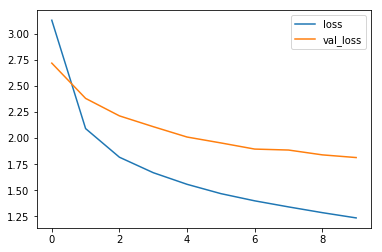

In [49]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

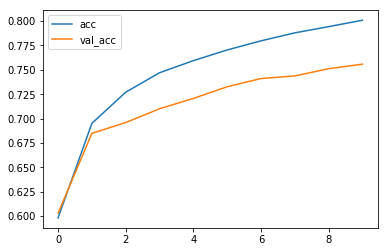

In [50]:
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()

### Generative Model 

In [51]:
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

In [52]:
encoder_outputs_as_input = Input(shape=(max_len_input, HIDDEN_DIM_ENCODER * 2,)) # note *2 because its bidirectional 

decoder_inputs_single = Input(shape=(1,))

decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [53]:
context = one_step_attention(encoder_outputs_as_input, initial_s)

In [54]:
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

In [55]:
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])

In [56]:
decoder_outputs = decoder_dense(o)

In [57]:
decoder_model = Model(inputs=[decoder_inputs_single,encoder_outputs_as_input,initial_s,initial_c],
                      outputs=[decoder_outputs,s,c])

In [58]:
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [59]:
def gen_model(input_seq):
  
    enc_out = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))


    target_seq[0, 0] = word2idx_outputs['<sos>']

    eos = word2idx_outputs['<eos>']



    s = np.zeros((1, HIDDEN_DIM_DECODER))
    c = np.zeros((1, HIDDEN_DIM_DECODER))



    output_sentence = []
    for _ in range(max_len_target):
        o, s, c = decoder_model.predict([target_seq, enc_out, s, c])



        idx = np.argmax(o.flatten())

        if eos == idx:
            break
    
        word = ''

        if idx > 0:

            word = idx2word_trans[idx]
            output_sentence.append(word)


        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [60]:
while True:

    i = np.random.choice(len(input_texts))
    
    English_input = encoder_inputs[i:i+1]
    
    translation = gen_model(English_input)
    
    print('------------')
    
    print('English Input:', input_texts[i])
    
    print('Predicted translation:', translation)
    
    print('Actual translation:', target_texts[i])

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith('n'):
        break

------------
English Input: Show it to her.
Predicted translation: lass es an.

Actual translation: Zeig sie ihr!
 <eos>
Continue? [Y/n]y
------------
English Input: I made Tom go.
Predicted translation: ich werde tom tom gesehen.

Actual translation: Ich habe Tom veranlasst zu gehen.
 <eos>
Continue? [Y/n]y
------------
English Input: We're reliable.
Predicted translation: wir sind zu zu hause.

Actual translation: Man kann sich auf uns verlassen.
 <eos>
Continue? [Y/n]y
------------
English Input: I found it.
Predicted translation: ich habe es gefunden.

Actual translation: Ich habe es gefunden.
 <eos>
Continue? [Y/n]y
------------
English Input: I'll go see.
Predicted translation: ich werde mich gehen.

Actual translation: Ich werde nachsehen.
 <eos>
Continue? [Y/n]y
------------
English Input: I feel so lost.
Predicted translation: ich bin nicht gehen.

Actual translation: Ich fühle mich so verloren.
 <eos>
Continue? [Y/n]n


Even after just 10 epochs we can see how powefull the Attention Mechanism truly is when compared with the standard seq2seq model